In [4]:
import jax3dp3 as j
import jax
import jax.numpy as jnp
import numpy as np
import os
import trimesh
import copy
import open3d as o3d

In [7]:
iter = 0
DATASET_FILENAME = f"tabletop_data_{iter}.npz"  # npz file
DATASET_FILE = os.path.join(j.utils.get_assets_dir(), f"datasets/{DATASET_FILENAME}")    

data = np.load(DATASET_FILE,allow_pickle=True)
original_intrinsics = j.Intrinsics(*data["intrinsics"])
intrinsics = j.camera.scale_camera_parameters(original_intrinsics, 0.1)
indices = jnp.array(data["indices"])
rgb = data["rgb"]
poses = jnp.array(data["poses"])
table_pose = jnp.array(data["table_pose"])
j.get_rgb_image(rgb)


renderer = j.Renderer(intrinsics)

model_dir = os.path.join(j.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    renderer.add_mesh_from_file(mesh_path)

table_params = data["table_params"]
table_mesh = j.mesh.make_table_mesh(
    *table_params
)
table_dims = j.utils.aabb(table_mesh.vertices)[0]
contact_plane = table_pose @ j.scene_graph.contact_planes(table_dims)[2]
renderer.add_mesh(table_mesh)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 512)


In [8]:

R_SWEEP = jnp.array([30.0, 5.0, 1.0, 0.1, 0.01]).reshape(-1,1)
OUTLIER_PROBS = jnp.linspace(0.01, 0.3, 4)
OUTLIER_VOLUME = 1000.0**3
SCALING_FACTOR = 3

contact_param_gridding_schedule = [
    j.make_translation_grid_enumeration_3d(
        -200.0, -200.0, -jnp.pi,
        200.0, 200.0, jnp.pi,
        11,11,5
    ),
    j.make_translation_grid_enumeration_3d(
        -20.0, -20.0, -jnp.pi/5,
        20.0, 20.0, jnp.pi/5,
        11,11,5
    ),
    j.make_translation_grid_enu`meration_3d(
        -2.0, -2.0, -jnp.pi/5/5,
        2.0, 2.0, jnp.pi/5/5,
        11,11,5
    ),
    j.make_translation_grid_enumeration_3d(
        -0.0, -0.0, -jnp.pi,
        0.0, 0.0, jnp.pi,
        1,1,7*7
    ),
    j.make_translation_grid_enumeration_3d(
        -0.5, -0.5, -jnp.pi/5/5,
        0.5, 0.5, jnp.pi/5/5,
        11,11,5
    ),

]

pose_from_contact_and_face_params_parallel_jit = jax.jit(jax.vmap(j.scene_graph.pose_from_contact_and_face_params, in_axes=(0,None, None, None)))


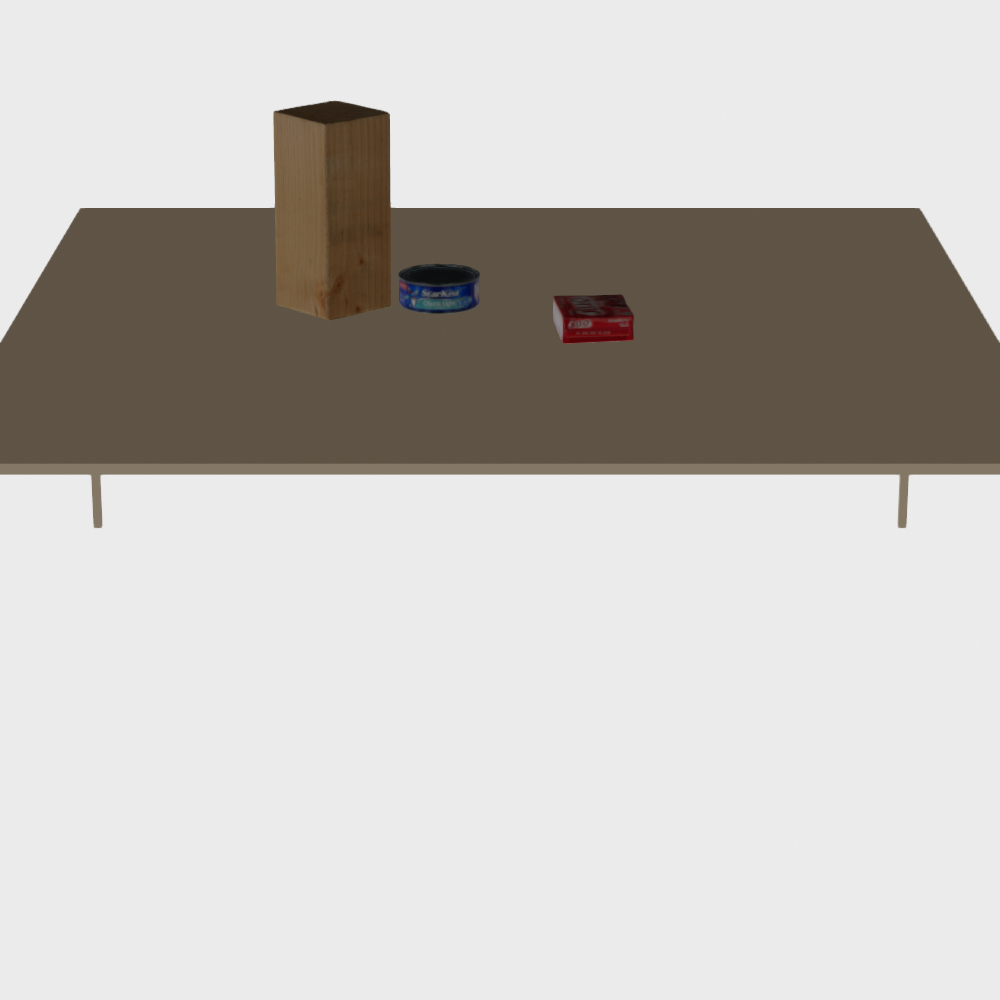

In [9]:
iter = 3
DATASET_FILENAME = f"tabletop_data_{iter}.npz"  # npz file
DATASET_FILE = os.path.join(j.utils.get_assets_dir(), f"datasets/{DATASET_FILENAME}")
    
data = np.load(DATASET_FILE,allow_pickle=True)
original_intrinsics = j.Intrinsics(*data["intrinsics"])
intrinsics = j.camera.scale_camera_parameters(original_intrinsics, 0.1)
indices = jnp.array(data["indices"])
rgb = data["rgb"]
poses = jnp.array(data["poses"])
table_pose = jnp.array(data["table_pose"])
j.get_rgb_image(rgb)


observed_point_cloud_image = renderer.render_multiobject(
    jnp.concatenate([poses]),
    jnp.concatenate([indices])
)
# j.get_rgb_image(rgb)
# j.overlay_image(
#     j.get_rgb_image(rgb),
# )

j.scale_image(j.get_depth_image(observed_point_cloud_image[:,:,2]), 10)
j.get_rgb_image(rgb)

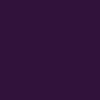

In [10]:
R = jnp.array([0.0001])
object_poses, object_ids = jnp.zeros((0,1,4,4)), []
reconstruction = renderer.render_multiobject(
    object_poses, object_ids
)


j.get_depth_image(reconstruction[:,:,2])

In [11]:
## all_hypotheses = []
for obj_id in range(21):
#     print("Object Id : ", obj_id)

    contact_param = jnp.zeros(3)
    p = None
    for c2f_iter in range(len(contact_param_gridding_schedule)):
        contact_param_grid = contact_param_gridding_schedule[c2f_iter] + contact_param
        
        potential_new_object_poses = pose_from_contact_and_face_params_parallel_jit(
            contact_param_grid,
            3,
            renderer.model_box_dims[obj_id],
            contact_plane
        )
        POTENTIAL_R = jnp.hstack([jnp.tile(R[None,:], (R_SWEEP.shape[0], 1)),R_SWEEP])

        potential_poses = jnp.concatenate(
            [
                jnp.tile(object_poses, (1,potential_new_object_poses.shape[0],1,1)),
                potential_new_object_poses[None,...]
            ]
        )
        reconstruction = renderer.render_multiobject_parallel(
            potential_poses, object_ids + [obj_id]
        )
        p = j.threedp3_likelihood_multi_r_full_hierarchical_bayes_jit(observed_point_cloud_image, reconstruction[:,:,:,:3], reconstruction[:,:,:, -1], POTENTIAL_R, OUTLIER_PROBS, OUTLIER_VOLUME)
        ii,jj,kk = jnp.unravel_index(p.argmax(), p.shape)
        contact_param = contact_param_grid[ii]
#         print(POTENTIAL_R[jj])

    best_r, best_outlier_prob = (POTENTIAL_R[jj], OUTLIER_PROBS[kk])

    all_hypotheses.append(
        (p[ii,jj,kk], reconstruction[ii], best_r, best_outlier_prob, potential_poses[:,ii], obj_id)
    )

scores = jnp.array([i[0] for i in all_hypotheses])
print(j.utils.normalize_log_scores(scores))
print(jnp.argsort(-scores))
best_hypothesis = all_hypotheses[jnp.argmax(scores)]
score, reconstruction, best_r, best_outlier_prob, best_poses, obj_id = best_hypothesis
print("Best")
print(best_r, best_outlier_prob, obj_id)

R = best_r
object_poses = best_poses[:,None,...]
object_ids = object_ids + [obj_id]


outliers = (
    (1.0 - best_outlier_prob) * (j.gaussian_mixture_image_multi_r_jit(observed_point_cloud_image, reconstruction[:,:,:3], reconstruction[:,:, -1], best_r))
        <
    (best_outlier_prob / OUTLIER_VOLUME)
)

# height_factor = outlier_prob_viz.height / observed_image_viz.height

viz1 = j.multi_panel(
    [j.scale_image(j.get_depth_image(r[1][:,:,2]), SCALING_FACTOR) for r in all_hypotheses],
    labels=["{:d} : {:0.3f}".format(idx, i[0].item()) for (idx,i) in enumerate(all_hypotheses)]
)
viz2 = j.multi_panel(
    [
        j.scale_image(j.get_depth_image(observed_point_cloud_image[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(reconstruction[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(1.0 *outliers), SCALING_FACTOR)
    ],
    labels=[
        "Observed Image",
        "Reconstruction {:d}".format(jnp.argmax(scores)),
        "Outliers",
    ],
    middle_width=30
)

viz2

2023-04-28 20:18:36.411838: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 11.07GiB (rounded to 11882200576)requested by op 
2023-04-28 20:18:36.412028: W external/tsl/tsl/framework/bfc_allocator.cc:497] *********************************************xxxx********_________________**********xxxx_____***x__*
2023-04-28 20:18:36.412186: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2432] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 11882200336 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   92.47MiB
              constant allocation:         0B
        maybe_live_out allocation:  461.58MiB
     preallocated temp allocation:   11.07GiB
  preallocated temp fragmentation:       128B (0.00%)
                 total allocation:   11.61GiB
              total fragmentation:  461.58MiB (3.88%)
Peak buffers:
	Buffer 1:
		Size: 5.52GiB

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 11882200336 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   92.47MiB
              constant allocation:         0B
        maybe_live_out allocation:  461.58MiB
     preallocated temp allocation:   11.07GiB
  preallocated temp fragmentation:       128B (0.00%)
                 total allocation:   11.61GiB
              total fragmentation:  461.58MiB (3.88%)
Peak buffers:
	Buffer 1:
		Size: 5.52GiB
		Operator: op_name="jit(threedp3_likelihood_multi_r)/jit(main)/reduce_sum[axes=(6,)]" source_file="/home/ubuntu/nishad/jax3dp3/jax3dp3/likelihood.py" source_line=28
		XLA Label: fusion
		Shape: f32[605,5,100,100,7,7]
		==========================

	Buffer 2:
		Size: 5.52GiB
		Operator: op_name="jit(threedp3_likelihood_multi_r)/jit(main)/log" source_file="/home/ubuntu/nishad/jax3dp3/jax3dp3/likelihood.py" source_line=28
		XLA Label: fusion
		Shape: f32[100,100,7,7,605,5]
		==========================

	Buffer 3:
		Size: 461.58MiB
		Operator: op_name="jit(threedp3_likelihood_multi_r)/jit(main)/add" source_file="/home/ubuntu/nishad/jax3dp3/jax3dp3/likelihood.py" source_line=35
		XLA Label: fusion
		Shape: f32[605,5,4,100,100]
		==========================

	Buffer 4:
		Size: 69.24MiB
		Entry Parameter Subshape: f32[605,100,100,3]
		==========================

	Buffer 5:
		Size: 23.08MiB
		Operator: op_name="jit(threedp3_likelihood_multi_r)/jit(main)/reduce[computation=<function _compute_argminmax.<locals>.reducer_fn at 0x7ff6b0426040> consts=() dimensions=(3,)]" source_file="/home/ubuntu/nishad/jax3dp3/jax3dp3/likelihood.py" source_line=56
		XLA Label: fusion
		Shape: s32[605,100,100]
		==========================

	Buffer 6:
		Size: 23.08MiB
		Entry Parameter Subshape: f32[605,100,100]
		==========================

	Buffer 7:
		Size: 156.2KiB
		Entry Parameter Subshape: f32[100,100,4]
		==========================

	Buffer 8:
		Size: 40B
		Entry Parameter Subshape: f32[5,2]
		==========================

	Buffer 9:
		Size: 16B
		Operator: op_name="jit(threedp3_likelihood_multi_r)/jit(main)/log" source_file="/home/ubuntu/nishad/jax3dp3/jax3dp3/likelihood.py" source_line=36
		XLA Label: fusion
		Shape: (f32[1], f32[4])
		==========================

	Buffer 10:
		Size: 16B
		Operator: op_name="jit(threedp3_likelihood_multi_r)/jit(main)/reduce[computation=<function _compute_argminmax.<locals>.reducer_fn at 0x7ff6b0426040> consts=() dimensions=(3,)]" source_file="/home/ubuntu/nishad/jax3dp3/jax3dp3/likelihood.py" source_line=56
		XLA Label: fusion
		Shape: (f32[605,100,100], s32[605,100,100])
		==========================

	Buffer 11:
		Size: 16B
		XLA Label: tuple
		Shape: (f32[], s32[])
		==========================

	Buffer 12:
		Size: 16B
		Operator: op_name="/select_n" source_file="/home/ubuntu/nishad/jax3dp3/jax3dp3/likelihood.py" source_line=56
		XLA Label: fusion
		Shape: (s32[], f32[])
		==========================

	Buffer 13:
		Size: 16B
		Entry Parameter Subshape: f32[4]
		==========================

	Buffer 14:
		Size: 4B
		XLA Label: parameter
		Shape: f32[]
		==========================

	Buffer 15:
		Size: 4B
		XLA Label: parameter
		Shape: s32[]
		==========================



[1.e-04 1.e+00 1.e-02 1.e+00 1.e-01]


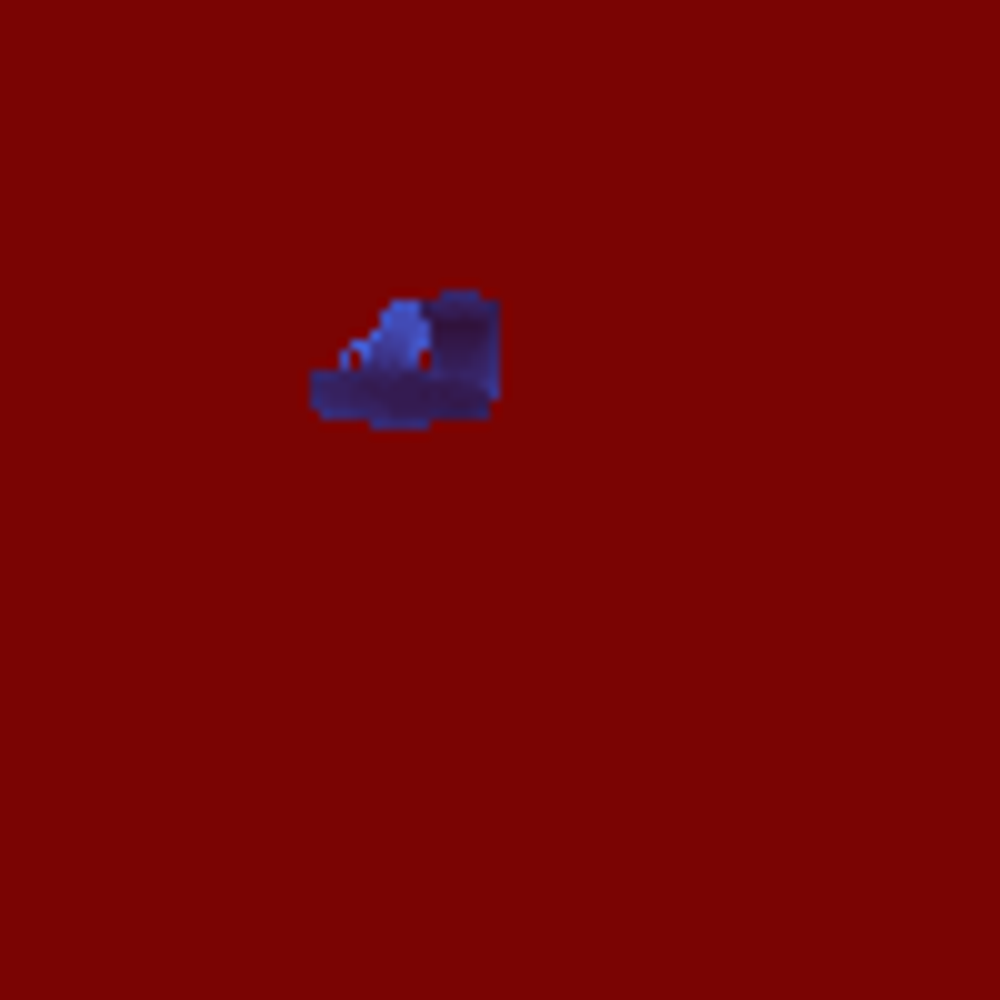

In [69]:
reconstruction = renderer.render_multiobject(
    object_poses, object_ids
)
rendered_seg = reconstruction[:,:,3]
j.get_depth_image(reconstruction[:,:,2])
r_array = R
print(r_array, )
r = r_array[jnp.abs(rendered_seg[..., None] - jnp.arange(len(r_array))).argmin(-1)]
key = jax.random.PRNGKey(10)
noisy_point_cloud_image = jax.random.multivariate_normal(
    key, reconstruction[:,:,:3], (jnp.eye(3)[None, None, :, :] * r[:,:,None,None]), shape=r.shape
)
img = j.render_point_cloud(noisy_point_cloud_image.reshape(-1,3), intrinsics)
j.scale_image(j.get_depth_image(img[:,:,2]),10)

In [57]:
print(object_ids)
print(indices)

[3, 5, 7]
[ 5  3 17]
